## <HR>CatBoost Model - Pipeline<HR>

### Import Required Packages

In [7]:
import json
import warnings
import numpy as np 
import pandas as pd
import xarray as xr
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from src.preprocessing import EnvironmentalFeaturesGenerator, GeographicalFeaturesGenerator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [8]:
DATA_PATH = '/kaggle/input/final-upload/'

In [9]:
wildfires_data = pd.read_csv(DATA_PATH+'wildfires_data.csv', parse_dates=['date'])
X = wildfires_data.iloc[:,~wildfires_data.columns.isin(['fire_type'])]
y = wildfires_data.fire_type

### Train, Validation, and Test set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=2020)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, shuffle=False, random_state=2020)

### 'load_NCEP_data' and 'load_Geo_data' methods to load the data into the memory

In [11]:
def load_NCEP_data():
    """NCEP data into the memory"""
    ncep_data, ncep_sfc_data = dict(), dict()
    #Mutli-dimensional ncep data at different pressure level and surface level
    for year in range(2012,2020):
        ncep_data[year] = xr.open_mfdataset('data/ncep/*.'+str(year)+'.nc', combine='by_coords', parallel=True)
        ncep_sfc_data[year] = xr.open_mfdataset('data/ncep/ncep_sfc/*.'+str(year)+'.nc', combine='by_coords', parallel=True)
    return ncep_data, ncep_sfc_data

def load_Geo_data():
    #forest
    forest_data = pd.read_csv(DATA_PATH+'additional/forest_coords.csv')
    #field
    field_data = pd.read_csv(DATA_PATH+'additional/field_coords.csv')
    field_data['field'] = field_data['field'].apply(lambda x: 2)
    #land data
    land_data = pd.concat([forest_data.rename({'forest': 'land_type'}, axis=1),
                           field_data.rename({'field': 'land_type'}, axis=1)]).reset_index(drop=True)
    #nature
    nature_forest_data = pd.read_csv(DATA_PATH+'additional/nature_forests.csv')
    #cities
    cities_data = pd.read_json(DATA_PATH+'additional/russian-cities.json')
    cities_data = pd.concat([pd.json_normalize(cities_data.coords), cities_data], axis=1)
    cities_data.drop('coords', axis=1, inplace=True)
    cities_data.rename(columns={"lat": "latitude", "lon": "longitude"}, inplace=True)
    cities_data['district'] = cities_data.district.astype('category').cat.codes
    cities_data['subject'] = cities_data.subject.astype('category').cat.codes
    return forest_data, field_data, land_data, nature_forest_data, cities_data

In [12]:
#drop irrelevant features 
drop_features = ['fire_id', 'date', 'fire_type_name', 'fire_type_name_en', 'day'] 
#golden_features for catboost classifier
golden_features = ['176:border_count=1024', '178:border_count=1024']

### CatBoost Model Pipeline

In [13]:
#
cat_classifier = CatBoostClassifier(iterations=6000, use_best_model=True, eval_metric='MultiClass',
                         od_type = 'IncToDec', l2_leaf_reg=5, 
                         per_float_feature_quantization = golden_features, 
                         loss_function='MultiClass', verbose=False, random_state=2020, 
                         task_type="GPU")

#
model_pipeline = Pipeline(steps=[('Env_Features', EnvironmentalFeaturesGenerator(*load_NCEP_data())),
                             ('Geo_Features', GeographicalFeaturesGenerator(*load_Geo_data())),
                             ('Drop_Features', FunctionTransformer(lambda X: X.drop(drop_features, axis=1))),
                             ('Fill_Missing_Values', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)),
                             ('Cat_Classifier', cat_classifier)],
                             verbose=True)

In [14]:
#preprocess validation set
pre_X_val = Pipeline(model_pipeline.steps[:-1], verbose=True).fit_transform(X_val)

[Pipeline] ...... (step 1 of 4) Processing Env_Features, total=   7.6s
[Pipeline] ...... (step 2 of 4) Processing Geo_Features, total=   0.8s
[Pipeline] ..... (step 3 of 4) Processing Drop_Features, total=   0.0s
[Pipeline]  (step 4 of 4) Processing Fill_Missing_Values, total=   0.1s


In [15]:
#train the catboost model
model_pipeline.fit(X_train, y_train, Cat_Classifier__eval_set=(pre_X_val, y_val))

[Pipeline] ...... (step 1 of 5) Processing Env_Features, total= 1.0min
[Pipeline] ...... (step 2 of 5) Processing Geo_Features, total=   1.3s
[Pipeline] ..... (step 3 of 5) Processing Drop_Features, total=   0.1s
[Pipeline]  (step 4 of 5) Processing Fill_Missing_Values, total=   0.5s
[Pipeline] .... (step 5 of 5) Processing Cat_Classifier, total= 3.2min


Pipeline(memory=None,
         steps=[('Env_Features',
                 <temp2.EnvironmentalFeaturesGenerator object at 0x7f8a9ca908d0>),
                ('Geo_Features',
                 <temp2.GeographicalFeaturesGenerator object at 0x7f8a9ca90990>),
                ('Drop_Features',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function <lambda> at 0x7f8a988c6680>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('Fill_Missing_Values',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=0,
                               missing_values=nan, strategy='constant',
                               verbose=0)),
                ('Cat_Classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f8a9ca90910>)],
         verbose=True)

### Model Performance

#### i) AUC-ROC

In [16]:
def get_roc_auc(y_true, y_prob):
    n_classes = 11
    one_hot_y_true = np.zeros((y_true.size, n_classes))
    one_hot_y_true[np.arange(y_true.size),y_true-1] = 1
    fpr, tpr = {}, {}
    roc_auc = {'roc_auc_micro': roc_auc_score(one_hot_y_true, y_prob, average='micro', multi_class="ovr")}
    for i in range(n_classes):
        if one_hot_y_true[:,i].sum():
            roc_auc[i] = roc_auc_score(one_hot_y_true[:,i], y_prob[:,i], multi_class="ovr")
        else:
            roc_auc[i] = 0.0
        fpr[i], tpr[i], _ = roc_curve(one_hot_y_true[:,i], y_prob[:,i])
    return roc_auc, fpr, tpr

In [18]:
n_classes = 11
roc_auc1 = get_roc_auc(y_train, model_pipeline.predict_proba(X_train))
roc_auc2 = get_roc_auc(y_val, model_pipeline.predict_proba(X_val))
roc_auc3 = get_roc_auc(y_test, model_pipeline.predict_proba(X_test))

columns_name = ['roc_auc_micro'] + ['roc_auc_fire_type_{0}'.format(i+1) for i in range(n_classes)]
pd.DataFrame([roc_auc1[0].values(),roc_auc2[0].values(),roc_auc3[0].values()], 
                 columns=columns_name, index=['train-set','val-set','test-set']).T

,train-set,val-set,test-set
roc_auc_micro,0.956116,0.883353,0.904450
roc_auc_fire_type_1,0.982785,0.937611,0.942533
roc_auc_fire_type_2,0.937717,0.718361,0.760613
roc_auc_fire_type_3,0.911783,0.806021,0.823803
roc_auc_fire_type_4,0.962506,0.904349,0.931091
roc_auc_fire_type_5,0.917814,0.807313,0.766619
roc_auc_fire_type_6,0.931622,0.859410,0.866859
roc_auc_fire_type_7,0.997325,0.000000,0.000000
roc_auc_fire_type_8,0.961697,0.860175,0.809732
roc_auc_fire_type_9,0.912171,0.818756,0.755117


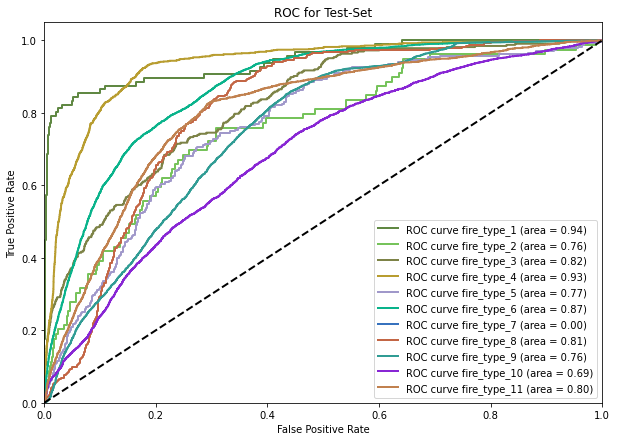

In [19]:
n_classes = 11
fpr, tpr = roc_auc3[1], roc_auc3[2]
np.random.seed(2020)
colors = [np.random.randint(256, size=3)/255 for _ in range(12)]


fig = plt.figure(figsize=(10,7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve fire_type_{0} (area = {1:0.2f})'.format(i+1, roc_auc3[0][i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Test-Set')
plt.legend(loc="lower right")
plt.show()

#### ii) Normalized confusion matrix

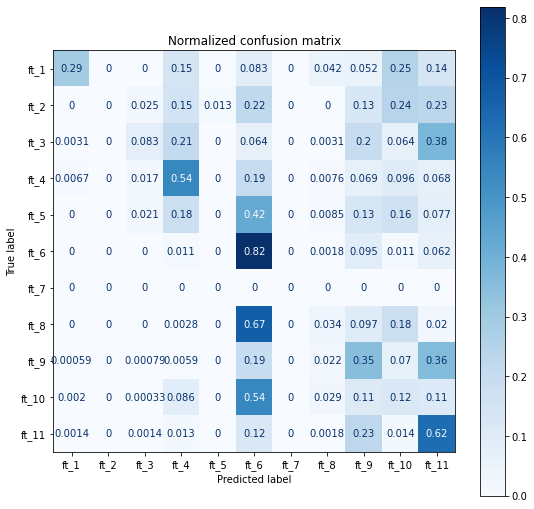

In [20]:
np.set_printoptions(precision=2)
class_names = ['ft_'+str(i) for i in range(1,12)]
fig, ax = plt.subplots(figsize=(9, 9))
disp = plot_confusion_matrix(model_pipeline, X_test, y_test,
                             display_labels=class_names,
                             labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                             cmap=plt.cm.Blues,
                             normalize='true', ax=ax)
disp.ax_.set_title("Normalized confusion matrix")
plt.show()